# Photo-thermal optical control in silicon waveguides

This example demonstrates the usage of the Tidy3D to calculate absorbed optical power, its resultant heating, and the corresponding optical heat perturbation on the silicon-on-insulator (SOI) platform.
<br><br>
Our setup is based on [All-optic control using a photo-thermal heater in Si photonics](https://opg.optica.org/oe/fulltext.cfm?uri=oe-30-23-41874) by L. Li, T. Tamanuki, and T. Baba. We build two parallel silicon rib waveguides separated by a gap of varying length. One waveguide (the "control" waveguide) has a triangular-shaped heavily doped region. This waveguide then absorbs an optical "control" signal, and the absorbed optical power heats both waveguides. The second waveguide (the "signal" waveguide) then has its refractive index perturbed by the change in temperature, and we analyze the resulting phase change of a signal sent through this waveguide.
<br><br>
This analysis is done for three gap lengths: 0.5 μm, 1.0 μm, and 1.5 μm. We first create the perturbation mediums with Tidy3D heat <i>and</i> charge perturbations in order to capture the properties of doped silicon. We then record the absorbed power and permittivity of the control waveguide, plot the resulting temperature change along the propagation (z) direction and along the y direction, and finally plot the heat-perturbed refractive index along z as well as the signal waveguide's phase change.
<br><br>
Thus our workflow will be: Control optical simulation $\rightarrow$ Heat simulation $\rightarrow$ Signal optical simulation

<center><img src="img/photothermal_waveguide.png" width="500" alt="Illustration of the photothermal waveguide setup"></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

First we describe some parameters that will remain constant throughout our simulations.

In [2]:
wvl0 = 1.55
freq0 = td.C_0 / wvl0

length = 30
wg_width = 0.45
wg_height = 0.11
slab_height = 0.11

## Perturbation Medium Setup

Because perturbing loss can result in numerical instabilities in our simulations, Tidy3D adds a warning about this when we define perturbation mediums. Since our perturbations will be small enough for stability, we will turn off Tidy3D warnings with the following command.

In [3]:
td.config.logging_level = "ERROR"

Here we define the [`MultiPhysicsMediums`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.components.material.multi_physics.MultiPhysicsMedium.html#tidy3d.components.material.multi_physics.MultiPhysicsMedium) of our simulation. To capture the absorption of doped silicon, we will perturb our silicon according to Tidy3D's charge perturbation. Here we will use the [`Nedeljkovic-Soref-Mashanovich`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.NedeljkovicSorefMashanovich.html) model with Li et. al.'s doping concentration.

In [4]:
ref_temp = 300
doping_concentration = 2.273e20
Si_heat_coeff = 0.00018

NSM = td.NedeljkovicSorefMashanovich(ref_freq=freq0)

# for maximum generality, we include charge in our index perturbations
Si = td.MultiPhysicsMedium(
    name="Si",
    optical=td.PerturbationMedium.from_nk(
        n=3.5,
        k=0,
        freq=freq0,
        perturbation_spec=td.IndexPerturbation(
            delta_n=td.ParameterPerturbation(
                heat=td.LinearHeatPerturbation(temperature_ref=ref_temp, coeff=Si_heat_coeff),
                charge=NSM.delta_n().charge,
            ),
            delta_k=td.ParameterPerturbation(charge=NSM.delta_k().charge),
            freq=freq0,
        ),
    ),
    heat=td.SolidSpec(
        conductivity=148e-6,  # W / (um * K)
        capacity=0.711,  # J / (kg * K)
    ),
)

Si_doped = td.MultiPhysicsMedium(
    name="Si doped",
    optical=td.PerturbationMedium.from_nk(
        n=3.5 + NSM.delta_n().charge.sample(doping_concentration, 0),
        k=0 + NSM.delta_k().charge.sample(doping_concentration, 0),
        freq=freq0,
        perturbation_spec=Si.optical.perturbation_spec,
    ),
    heat=Si.heat,
)

SiO2 = td.MultiPhysicsMedium(
    name="SiO2",
    optical=td.PerturbationMedium(
        permittivity=1.44**2,
        perturbation_spec=td.IndexPerturbation(
            delta_n=td.ParameterPerturbation(
                heat=td.LinearHeatPerturbation(temperature_ref=ref_temp, coeff=0.000012)
            ),
            freq=freq0,
        ),
    ),
    heat=td.SolidSpec(
        conductivity=1.38e-6,  # W / (um * K)
        capacity=709,  # J / (kg * K)
    ),
)

## First Optical Simulation

Here we create a function that takes in a gap length and returns a Tidy3D simulation with the corresponding two-waveguide structure. The simulations returned will be our first optical simulations - that is, a simulation where we launch a TE mode and record the field and permittivity along the control waveguide, as this will be used to compute the absorbed power. We also add a field monitor along the propagation direction to visualize the optical power being absorbed along the waveguide.

In [5]:
def make_sim(gap):
    z_min, z_max = -length / 2.0, length / 2.0
    sim_buffer = 4

    # Waveguides (above slab) in y; separated in x
    wg_signal_x_min, wg_signal_x_max = gap / 2.0, gap / 2.0 + wg_width
    wg_control_x_min, wg_control_x_max = -gap / 2.0 - wg_width, -gap / 2.0

    wg_signal_box = td.Box.from_bounds(
        rmin=(wg_signal_x_min, 0.0, -td.inf), rmax=(wg_signal_x_max, wg_height, td.inf)
    )
    wg_control_box = td.Box.from_bounds(
        rmin=(wg_control_x_min, 0.0, -td.inf),
        rmax=(wg_control_x_max, wg_height, td.inf),
    )

    # Slab (below guides)
    slab_y_min, slab_y_max = -slab_height, 0.0
    slab_x_min = wg_control_x_min
    slab_x_max = wg_signal_x_max + 0.5
    slab_box = td.Box.from_bounds(
        rmin=(slab_x_min, slab_y_min, -td.inf), rmax=(slab_x_max, slab_y_max, td.inf)
    )

    # Triangular prism: hypotenuse aligned with z (length) direction
    tri_vertices = [
        (wg_control_x_min, z_max),
        (wg_control_x_min, z_min),
        (wg_control_x_max, z_min),
    ]
    tri_geom = td.PolySlab(vertices=tri_vertices, axis=1, slab_bounds=(0.0, wg_height))

    slab = td.Structure(geometry=slab_box, medium=Si, name="slab")
    wg_signal = td.Structure(geometry=wg_signal_box, medium=Si, name="wg_signal")
    wg_control = td.Structure(geometry=wg_control_box, medium=Si, name="wg_control")
    tri = td.Structure(geometry=tri_geom, medium=Si_doped, name="doped triangle")

    slab_width = slab_x_max - slab_x_min
    margin_x = max(0.5 * wvl0 + 0.1, 0.5)

    sim_center = (0.5 * (slab_x_max + slab_x_min), 0.5 * (wg_height + slab_y_min), 0.0)
    sim_size = (
        slab_width + 2 * margin_x,
        wvl0 + (wg_height - slab_y_min),
        length + sim_buffer,
    )

    tri_min, tri_max = tri.geometry.bounds
    tri_center = tuple(0.5 * (a + b) for a, b in zip(tri_min, tri_max))
    tri_size = tuple(a - b for a, b in zip(tri_max, tri_min))

    tri_monitor = td.FieldMonitor(
        center=tri_center,
        size=tri_size,
        fields=["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"],
        freqs=[freq0],
        name="field",
    )

    perm_monitor = td.PermittivityMonitor(
        center=tri_center, size=tri_size, freqs=[freq0], name="tri_permittivity"
    )

    plane_monitor = td.FieldMonitor(
        center=(sim_center[0], wg_height / 2, sim_center[2]),
        size=(sim_size[0], 0, sim_size[2]),
        fields=["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"],
        freqs=[freq0],
        name="midplane_field",
    )

    clearance = min(0.05, 0.25 * gap) if gap > 0 else 0.01
    clearance = max(clearance, 1e-3)
    buffer_x = max(0.2, 0.5 * wg_width)
    buffer_y = max(0.1, 0.2 * wg_height)
    extra_x = max(0.3, 0.5 * wg_width)
    extra_y = max(0.5, 1.5 * wg_height)

    source_x_min = wg_control_x_min - (buffer_x + extra_x)
    source_x_max = wg_signal_x_min - clearance
    if source_x_max <= source_x_min:
        mid = 0.5 * (wg_control_x_max + wg_signal_x_min)
        source_x_min = min(wg_control_x_min - (0.1 * wg_width + extra_x), mid - 0.05)
        source_x_max = max(mid, wg_signal_x_min - 1e-3)

    source_y_min = -buffer_y - extra_y
    source_y_max = wg_height + buffer_y + extra_y

    mode_center = (
        0.5 * (source_x_min + source_x_max),
        0.5 * (source_y_min + source_y_max),
        z_max + 0.1,
    )
    mode_size = (source_x_max - source_x_min, source_y_max - source_y_min, 0.0)

    mode_source = td.ModeSource(
        center=mode_center,
        size=mode_size,
        direction="-",
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        mode_spec=td.ModeSpec(num_modes=1),
    )

    simulation = td.Simulation(
        center=sim_center,
        size=sim_size,
        structures=[slab, wg_signal, wg_control, tri],
        sources=[mode_source],
        monitors=[tri_monitor, perm_monitor, plane_monitor],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl0),
        medium=SiO2.optical,
        run_time=5e-13,
    )

    return simulation

In [6]:
sim_0p5 = make_sim(0.5)
sim_1p0 = make_sim(1.0)
sim_1p5 = make_sim(1.5)

We visualize a constructed simulation to ensure the setup is correct.

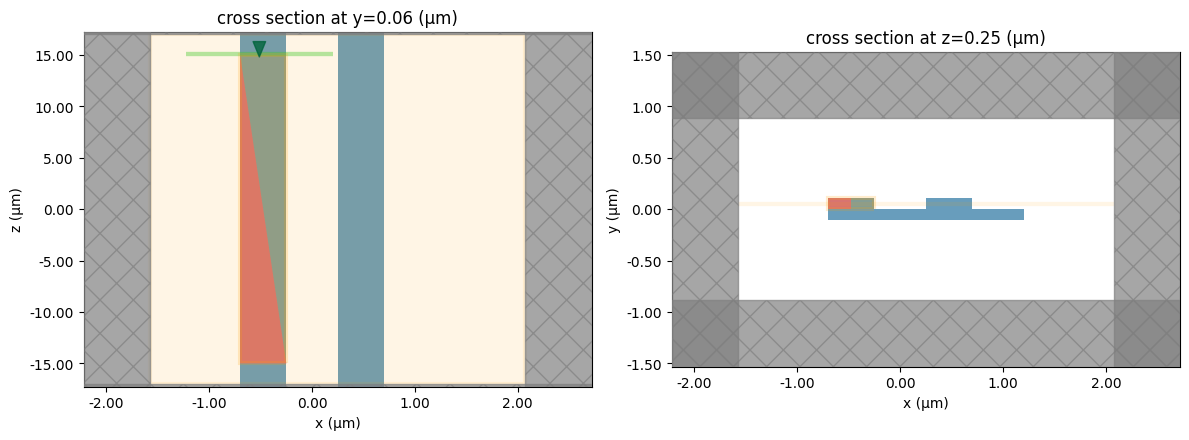

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sim_0p5.plot(y=wg_height / 2, ax=ax[0], monitor_alpha=0.1)
sim_0p5.plot(z=sim_0p5.center[0], ax=ax[1], monitor_alpha=0.1)
ax[0].set_aspect(0.1)
plt.tight_layout()

We run the three constructed simulations.

In [8]:
sims = {"0.5": sim_0p5, "1.0": sim_1p0, "1.5": sim_1p5}
run_results = {}
for label, sim in sims.items():
    result = web.run(sim, task_name=f"sim_gap_{label}")
    run_results[label] = result

19:14:54 EDT Created task 'sim_gap_0.5' with resource_id                        
             'fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=782284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=730075;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\taskId]8;;\]8;id=782284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\=]8;;\]8;id=246125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\fdve]8;;\]8;id=782284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\-d71b8ec3-967]8;;\
             ]8;id=782284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d71b8ec3-9673-44cc-bc85-c32915b0a103\3-44cc-bc85-c32915b0a103']8;;\.

             Task folder: ]8;id=429157;https://tidy3d.simulation.cloud/folders/folder-86acd7be-dbf5-477e-9c86-3e20787acc03\'default']8;;\.

Output()

19:14:56 EDT Estimated FlexCredit cost: 0.061. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = success

Output()

19:14:59 EDT loading simulation from simulation_data.hdf5

             Created task 'sim_gap_1.0' with resource_id                        
             'fdve-48052617-df61-4991-b8c6-5dbd3d2caafe' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=590265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=844092;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\taskId]8;;\]8;id=590265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\=]8;;\]8;id=448536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\fdve]8;;\]8;id=590265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\-48052617-df6]8;;\
             ]8;id=590265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48052617-df61-4991-b8c6-5dbd3d2caafe\1-4991-b8c6-5dbd3d2caafe']8;;\.

             Task folder: ]8;id=325104;https://tidy3d.simulation.cloud/folders/folder-86acd7be-dbf5-477e-9c86-3e20787acc03\'default']8;;\.

Output()

19:15:00 EDT Estimated FlexCredit cost: 0.070. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:15:01 EDT status = success

Output()

19:15:02 EDT loading simulation from simulation_data.hdf5

19:15:03 EDT Created task 'sim_gap_1.5' with resource_id                        
             'fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=272812;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=475661;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\taskId]8;;\]8;id=272812;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\=]8;;\]8;id=378243;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\fdve]8;;\]8;id=272812;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\-3946d53e-f0a]8;;\
             ]8;id=272812;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3946d53e-f0a4-4478-8d79-b6154b53ac0b\4-4478-8d79-b6154b53ac0b']8;;\.

             Task folder: ]8;id=154096;https://tidy3d.simulation.cloud/folders/folder-86acd7be-dbf5-477e-9c86-3e20787acc03\'default']8;;\.

Output()

19:15:04 EDT Estimated FlexCredit cost: 0.079. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:15:05 EDT status = success

Output()

19:15:06 EDT loading simulation from simulation_data.hdf5

We will visualize the mode getting absorbed as it propagates through the control waveguide for each simulation.

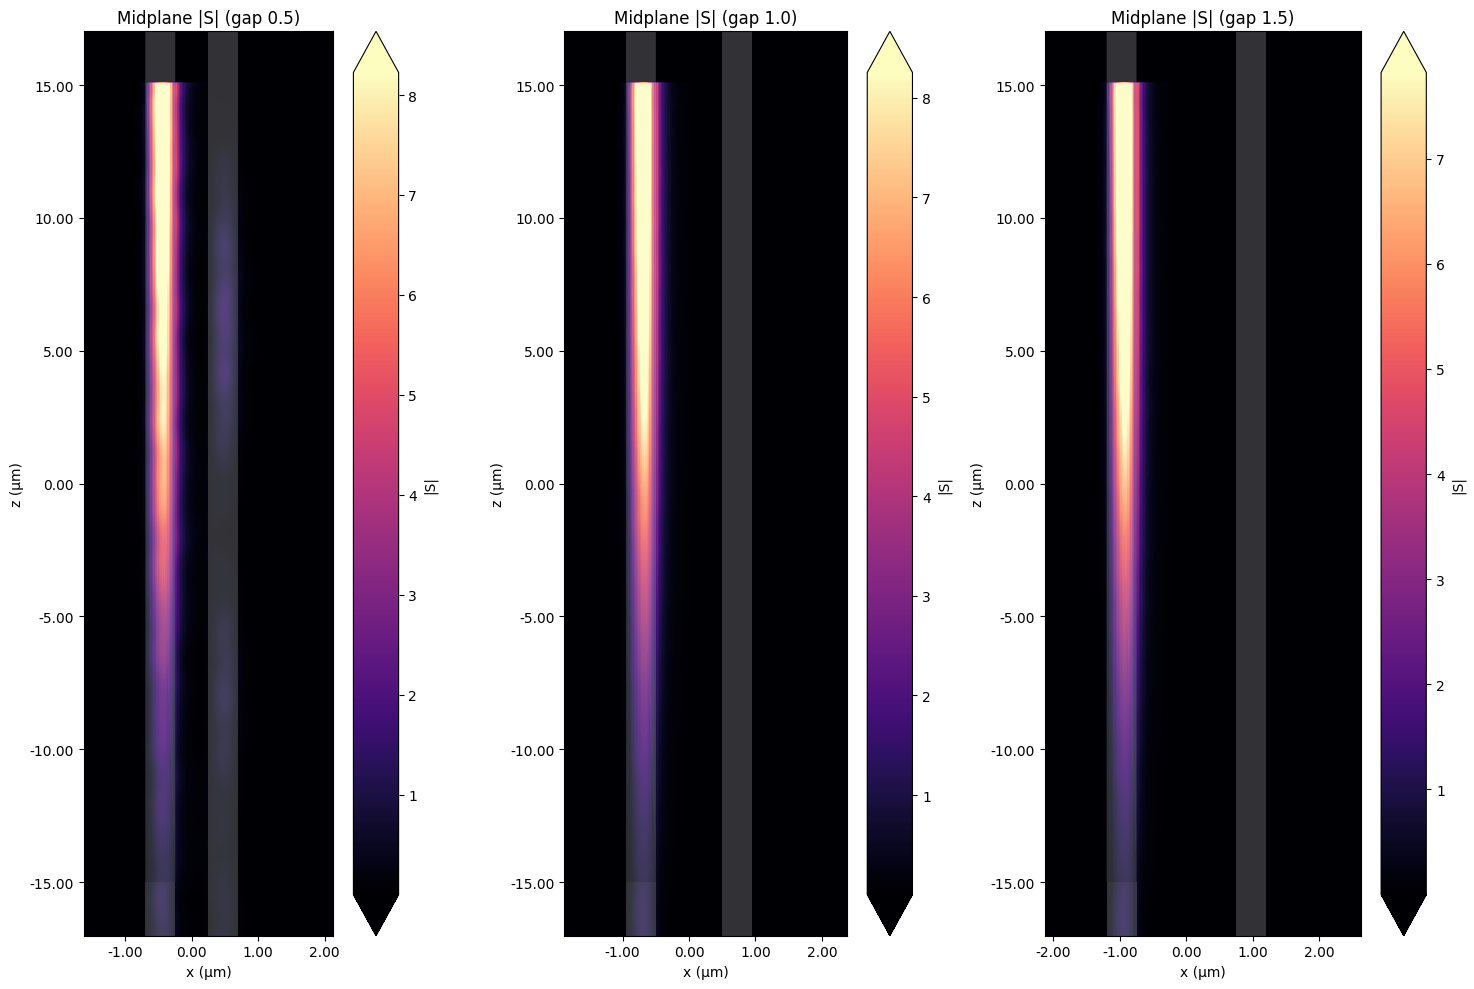

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for ax, label in zip(axes, ["0.5", "1.0", "1.5"]):
    run_results[label].plot_field("midplane_field", field_name="S", val="abs", f=freq0, ax=ax)
    ax.set_title(f"Midplane |S| (gap {label})")
    ax.set_aspect(0.4)

plt.tight_layout()

## Heat Simulation

We will now use the recorded field and permittivity along the control waveguide to compute the absorbed power. The absorbed power is given by the formula
<center>$P = \frac{1}{2}\omega|E|^2$ $im(\epsilon)$</center><br>

We construct a function that creates a heat source as a [`SpatialDataArray`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SpatialDataArray.html), using the coordinates of the field monitor and interpolating the permittivity monitor data to these points.

In [10]:
def absorbed_power(field_data, permittivity_data, freq):
    """Return 0.5 * 2π * freq * |E|^2 * imag(permittivity) on the field grid."""
    if not isinstance(field_data, td.FieldData):
        raise TypeError("field_data must be a tidy3d.FieldData.")
    if not isinstance(permittivity_data, td.PermittivityData):
        raise TypeError("permittivity_data must be a tidy3d.PermittivityData.")
    missing = [comp for comp in ("Ex", "Ey", "Ez") if comp not in dir(field_data)]
    if missing:
        raise KeyError(f"Missing field components in field_data: {missing}")
    if (
        permittivity_data.eps_xx != permittivity_data.eps_yy
        or permittivity_data.eps_yy != permittivity_data.eps_zz
    ):
        raise ValueError("Permittivity_data must be isotropic.")

    coords = field_data.Ex.coords
    coords_dict = {dim: coords.get(dim) for dim in "xyz"}

    # perm_interp = permittivity_data.eps_xx.interp(field_data.Ex.coords, method="nearest")
    perm_interp = permittivity_data.eps_xx.interp(**coords_dict)

    E = np.abs(field_data.Ex) ** 2 + np.abs(field_data.Ey) ** 2 + np.abs(field_data.Ez) ** 2
    perm_imag = np.imag(perm_interp).sel(f=freq, method="nearest") * td.EPSILON_0
    absorption = 0.5 * 2 * np.pi * freq * E.sel(f=freq, method="nearest") * perm_imag

    return td.SpatialDataArray(absorption, coords=coords_dict)

In [11]:
heat_rate_0p5 = absorbed_power(
    run_results["0.5"]["field"], run_results["0.5"]["tri_permittivity"], freq0
)
heat_rate_1p0 = absorbed_power(
    run_results["1.0"]["field"], run_results["1.0"]["tri_permittivity"], freq0
)
heat_rate_1p5 = absorbed_power(
    run_results["1.5"]["field"], run_results["1.5"]["tri_permittivity"], freq0
)

Using the absorbed power data we calculated, we create the heat source by assigning it to the optical waveguide structure.

In [12]:
heat_source_0p5 = td.HeatSource(structures=["wg_control"], rate=heat_rate_0p5)
heat_source_1p0 = td.HeatSource(structures=["wg_control"], rate=heat_rate_1p0)
heat_source_1p5 = td.HeatSource(structures=["wg_control"], rate=heat_rate_1p5)

Next we will construct a temperature monitor around the signal waveguide so we can heat-perturb the signal structure.

In [13]:
def make_temp_monitor(sim):
    rmin, rmax = sim.structures[-1].geometry.bounds
    size_z = rmax[2] - rmin[2]
    temp_monitor = td.TemperatureMonitor(
        center=sim.structures[1].geometry.center,
        size=(sim.sources[0].size[0], sim.sources[0].size[1], size_z),
        name="temp",
        unstructured=True,
        conformal=True,
    )
    return temp_monitor


temp_monitor_0p5 = make_temp_monitor(sims["0.5"])
temp_monitor_1p0 = make_temp_monitor(sims["1.0"])
temp_monitor_1p5 = make_temp_monitor(sims["1.5"])

We also define the discretization for our heat simulations.

In [14]:
# parameters for meshing
dl_min = slab_height / 3
dl_max = 3 * dl_min

grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=dl_max,
    distance_interface=3 * dl_min,
    distance_bulk=slab_height,
)

We define boundary specs for our heat simulations.

In [15]:
boundaries = td.HeatBoundarySpec(
    placement=td.SimulationBoundary(surfaces=["y-", "y+", "x-", "x+"]),
    condition=td.TemperatureBC(temperature=ref_temp),
)

We now combine the structures, computed heat source, temperature monitor, discretization, and boundary conditions into Tidy3D Heat simulations.

In [16]:
heat_sim_0p5 = td.HeatChargeSimulation(
    center=sims["0.5"].center,
    size=[sims["0.5"].size[0] * 1.5, sims["0.5"].size[1] * 1.5, sims["0.5"].size[2]],
    medium=SiO2,
    structures=sims["0.5"].structures,
    sources=[heat_source_0p5],
    monitors=[temp_monitor_0p5],
    grid_spec=grid_spec,
    boundary_spec=[boundaries],
)

heat_sim_1p0 = td.HeatChargeSimulation(
    center=sims["1.0"].center,
    size=[sims["1.0"].size[0] * 1.5, sims["1.0"].size[1] * 1.5, sims["1.0"].size[2]],
    medium=SiO2,
    structures=sims["1.0"].structures,
    sources=[heat_source_1p0],
    monitors=[temp_monitor_1p0],
    grid_spec=grid_spec,
    boundary_spec=[boundaries],
)

heat_sim_1p5 = td.HeatChargeSimulation(
    center=sims["1.5"].center,
    size=[sims["1.5"].size[0] * 1.5, sims["1.5"].size[1] * 1.5, sims["1.5"].size[2]],
    medium=SiO2,
    structures=sims["1.5"].structures,
    sources=[heat_source_1p5],
    monitors=[temp_monitor_1p5],
    grid_spec=grid_spec,
    boundary_spec=[boundaries],
)

We run the heat simulations.

In [17]:
heat_data_0p5 = web.run(heat_sim_0p5, task_name="heat_sim_0p5")
heat_data_1p0 = web.run(heat_sim_1p0, task_name="heat_sim_1p0")
heat_data_1p5 = web.run(heat_sim_1p5, task_name="heat_sim_1p5")

19:15:08 EDT Created task 'heat_sim_0p5' with resource_id                       
             'hec-c34e3746-9d1b-49ea-956c-dda7a70a1188' and task_type           
             'HEAT_CHARGE'.

19:15:09 EDT Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

19:15:10 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:15:11 EDT status = success

Output()

19:15:12 EDT loading simulation from simulation_data.hdf5

             Created task 'heat_sim_1p0' with resource_id                       
             'hec-c0ae4c25-1af3-407e-9e03-64e90745a224' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

19:15:14 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:15:15 EDT status = success

Output()

19:15:16 EDT loading simulation from simulation_data.hdf5

             Created task 'heat_sim_1p5' with resource_id                       
             'hec-6cec850c-2297-4bc4-ba35-d91a68c10cc5' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

19:15:18 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = success

Output()

19:15:20 EDT loading simulation from simulation_data.hdf5

To visualize our temperature distribution from the heat source, we can add an interactive plot to show a cross-section of the signal waveguide sliding along the propagation (z) axis.

In [18]:
# adjust for different sims
temp_data = heat_data_0p5


import ipywidgets as widgets

zs = np.linspace(
    temp_data["temp"].monitor.center[2] - temp_data["temp"].monitor.size[2] / 2,
    temp_data["temp"].monitor.center[2] + temp_data["temp"].monitor.size[2] / 2,
    61,
)

hmin = temp_data["temp"].monitor.center[0] - temp_data["temp"].monitor.size[0] / 2
hmax = temp_data["temp"].monitor.center[0] + temp_data["temp"].monitor.size[0] / 2
vmin = temp_data["temp"].monitor.center[1] - temp_data["temp"].monitor.size[1] / 2
vmax = temp_data["temp"].monitor.center[1] + temp_data["temp"].monitor.size[1] / 2

field_slider = widgets.FloatSlider(
    value=4,
    min=zs[0],
    max=zs[-1],
    step=None,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_wg_plot(x):
    if x not in zs:
        x = min(zs, key=lambda zz: abs(zz - x))
    fig, ax = plt.subplots(figsize=(6, 5))
    slice_temp = temp_data["temp"].temperature.plane_slice(axis=2, pos=x)
    slice_temp.plot(
        cmap="jet", grid=False, vmax=np.max(temp_data["temp"].temperature.values), ax=ax
    )
    temp_data.simulation.plot_structures(
        z=x, fill=False, ax=ax, hlim=[hmin, hmax], vlim=[vmin, vmax]
    )
    ax.set_title(f"Temperature at z = {x:.3f} µm")
    plt.tight_layout()
    plt.show()


widgets.interactive(update_wg_plot, x=field_slider)

interactive(children=(FloatSlider(value=4.0, description='x', max=15.0, min=-15.0, readout_format='.3f', step=…

We will also plot the temperature profile through the middle of the structure to show the distribution along the waveguide all at once.

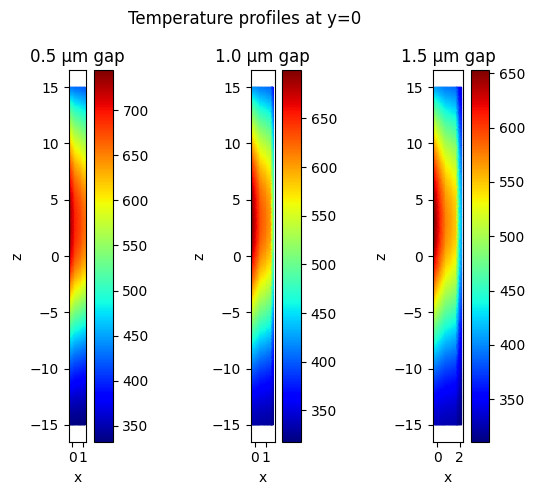

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(6, 5))
heat_data_0p5["temp"].temperature.plane_slice(axis=1, pos=0).plot(grid=False, cmap="jet", ax=ax[0])
heat_data_1p0["temp"].temperature.plane_slice(axis=1, pos=0).plot(grid=False, cmap="jet", ax=ax[1])
heat_data_1p5["temp"].temperature.plane_slice(axis=1, pos=0).plot(grid=False, cmap="jet", ax=ax[2])

ax[0].set_title("0.5 µm gap")
ax[1].set_title("1.0 µm gap")
ax[2].set_title("1.5 µm gap")

fig.suptitle("Temperature profiles at y=0")
plt.tight_layout()
plt.show()

From this temperature distribution, we see that the middle section should have more of a perturbation. To verify this, we will visualize the change in refractive index along the propagation direction of the signal waveguide.

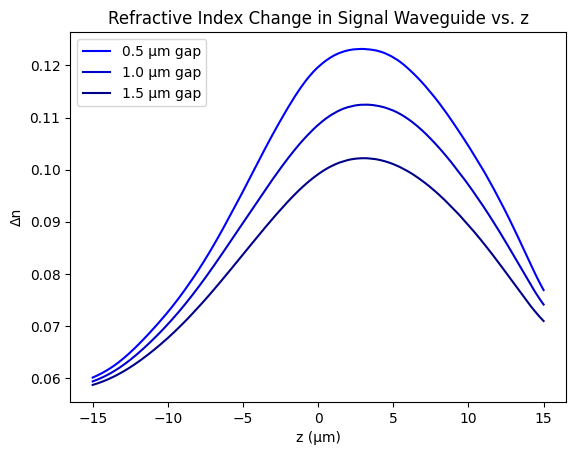

In [20]:
heat_line_0p5 = heat_data_0p5["temp"].temperature.line_slice(
    axis=2, pos=sims["0.5"].structures[1].geometry.center
)
heat_line_1p0 = heat_data_1p0["temp"].temperature.line_slice(
    axis=2, pos=sims["1.0"].structures[1].geometry.center
)
heat_line_1p5 = heat_data_1p5["temp"].temperature.line_slice(
    axis=2, pos=sims["1.5"].structures[1].geometry.center
)

plt.plot(
    heat_line_0p5.z,
    np.squeeze(heat_line_0p5.data) * Si_heat_coeff,
    color="blue",
    label="0.5 µm gap",
)
plt.plot(
    heat_line_1p0.z,
    np.squeeze(heat_line_1p0.data) * Si_heat_coeff,
    color="mediumblue",
    label="1.0 µm gap",
)
plt.plot(
    heat_line_1p5.z,
    np.squeeze(heat_line_1p5.data) * Si_heat_coeff,
    color="darkblue",
    label="1.5 µm gap",
)

plt.xlabel("z (µm)")
plt.ylabel("Δn")
plt.title("Refractive Index Change in Signal Waveguide vs. z")
plt.legend()
plt.show()

## Final Optical Simulation

We are now in a position to see the effect on the signal waveguide from the control signal through the control waveguide. We create a function that modifies our first optical simulations into ones that launch and measure the TE mode through the signal waveguide. Then, using the temperature data of the previous heat simulations, we create heat-perturbed copies to compute the phase changes.

In [21]:
def update_sim_signal_source(sim):
    new_source = sim.sources[0].updated_copy(
        center=(
            sim.structures[1].geometry.center[0],
            sim.sources[0].center[1],
            sim.sources[0].center[2],
        )
    )
    new_monitor = td.ModeMonitor(
        center=(
            sim.structures[1].geometry.center[0],
            sim.structures[1].geometry.center[1],
            sim.center[2] - sim.size[2] / 2 + 1,
        ),
        size=new_source.size,
        name="mode",
        freqs=[freq0],
        mode_spec=new_source.mode_spec,
    )

    new_sim = sim.updated_copy(sources=[new_source], monitors=[new_monitor], medium=SiO2.optical)
    return new_sim


sims_opt, sims_opt_perturbed = {}, {}

sims_opt["0.5"] = update_sim_signal_source(sims["0.5"])
sims_opt["1.0"] = update_sim_signal_source(sims["1.0"])
sims_opt["1.5"] = update_sim_signal_source(sims["1.5"])

sims_opt_perturbed["0.5"] = sims_opt["0.5"].perturbed_mediums_copy(
    temperature=heat_data_0p5["temp"].temperature
)
sims_opt_perturbed["1.0"] = sims_opt["1.0"].perturbed_mediums_copy(
    temperature=heat_data_1p0["temp"].temperature
)
sims_opt_perturbed["1.5"] = sims_opt["1.5"].perturbed_mediums_copy(
    temperature=heat_data_1p5["temp"].temperature
)

We create batches for the perturbed and unperturbed simulations and run them.

In [22]:
opt_unperturbed_batch = td.web.Batch(simulations=sims_opt)
opt_perturbed_batch = td.web.Batch(simulations=sims_opt_perturbed)

# Run all the simulations and get the results.
opt_unperturbed = opt_unperturbed_batch.run()
opt_perturbed = opt_perturbed_batch.run()

Output()

19:16:00 EDT Started working on Batch containing 3 tasks.

19:16:02 EDT Maximum FlexCredit cost: 0.221 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

19:16:05 EDT Batch complete.

Output()

Output()

19:18:19 EDT Started working on Batch containing 3 tasks.

19:20:21 EDT Maximum FlexCredit cost: 0.221 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

19:20:23 EDT Batch complete.

Output()

We now compute the phase changes between the heated and unheated simulations for each gap, and plot the phase change vs gap length.

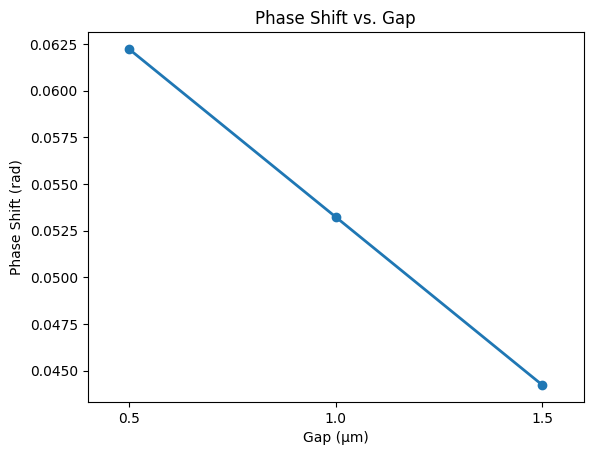

In [23]:
phase_0p5_unp = np.angle(opt_unperturbed["0.5"]["mode"].amps.sel(direction="-").values)
phase_0p5_p = np.angle(opt_perturbed["0.5"]["mode"].amps.sel(direction="-").values)

phase_1p0_unp = np.angle(opt_unperturbed["1.0"]["mode"].amps.sel(direction="-").values)
phase_1p0_p = np.angle(opt_perturbed["1.0"]["mode"].amps.sel(direction="-").values)

phase_1p5_unp = np.angle(opt_unperturbed["1.5"]["mode"].amps.sel(direction="-").values)
phase_1p5_p = np.angle(opt_perturbed["1.5"]["mode"].amps.sel(direction="-").values)

phase_shift_0p5 = np.squeeze(phase_0p5_p - phase_0p5_unp)
phase_shift_1p0 = np.squeeze(phase_1p0_p - phase_1p0_unp)
phase_shift_1p5 = np.squeeze(phase_1p5_p - phase_1p5_unp)

phase_shifts = [phase_shift_0p5, phase_shift_1p0, phase_shift_1p5]

plt.plot(
    [0.5, 1.0, 1.5],
    phase_shifts,
    marker="o",
    linestyle="-",
    linewidth=2,
    color="tab:blue",
)
plt.xticks([0.5, 1.0, 1.5])
plt.xlabel("Gap (µm)")
plt.ylabel("Phase Shift (rad)")
plt.title("Phase Shift vs. Gap")
plt.xlim(0.4, 1.6)
plt.show()